### Keras Example
Logistic regression for structured data on the Titanic dataset

***
#### Environment
`conda activate tf-env`

***
#### Goals
- Explore Tensorflow via Keras API

***
#### References

https://keras.io/  
https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers  

#### Basic python imports

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=3, suppress=True)
from IPython.display import display

#### Dataset load using sklearn API from https://www.openml.org site

https://www.openml.org/d/40945

If the URL does not work the dataset can be loaded from the data folder `./data/titanic/`. 

In [2]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/40945
raw_dataset = fetch_openml("titanic", version=1, as_frame=True).frame
raw_dataset.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Convert categorical numeric columns pclass , sibsp and parch to int values
# Drop un-used columns.
raw_dataset.pclass = raw_dataset.pclass.astype(int)
raw_dataset.sibsp = raw_dataset.sibsp.astype(int)
raw_dataset.parch = raw_dataset.parch.astype(int)
dataset = raw_dataset.copy().drop(columns=['name','ticket','cabin','boat', 'body', 'home.dest'])
display(dataset.describe().transpose())
display(dataset.info())
display(dataset.isna().sum())

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   int32   
 1   survived  1309 non-null   category
 2   sex       1309 non-null   category
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   int32   
 5   parch     1309 non-null   int32   
 6   fare      1308 non-null   float64 
 7   embarked  1307 non-null   category
dtypes: category(3), float64(2), int32(3)
memory usage: 40.1 KB


None

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [4]:
# Remove NA
dataset = dataset.dropna()
#dataset.info()

### Prepare train, validation and test datasets

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

667 train examples
167 validation examples
209 test examples


In [6]:
import tensorflow as tf

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('survived').astype(int)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [8]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_tokens=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

In [9]:
batch_size = 100
train_ds = df_to_dataset(train, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )

Every feature: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
A batch of ages: tf.Tensor(
[31.    19.    32.    22.     9.    21.    70.    36.    30.    54.
 31.    26.     2.    14.    40.    31.    20.    23.    28.     9.
 29.    33.    35.    32.    24.    12.    26.    18.    38.    31.
 50.    31.    24.    21.    33.    21.    47.    35.    47.    39.
 30.    76.    25.    25.    30.    45.    45.    22.    19.    18.
 11.5   25.    18.    52.    62.     0.417 58.    29.    45.    54.
 48.    64.    18.    17.    11.    42.    37.    32.    17.    20.
 24.    23.    38.    31.    36.    31.    22.     9.    48.    39.
 47.    30.5   52.    18.    28.    40.    22.    54.     6.     8.
 48.    21.    32.    19.    28.    34.    24.    28.    49.    23.   ], shape=(100,), dtype=float64)
A batch of targets: tf.Tensor(
[0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1
 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0

In [11]:
test.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
1140,3,0,male,21.0,0,0,8.0500,S
1107,3,0,male,21.0,0,0,8.6625,S
905,3,1,male,32.0,0,0,7.8542,S
374,2,0,male,29.0,0,0,10.5000,S
417,2,0,male,26.0,0,0,10.5000,S


### Build the pipeline components

In [12]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['age', 'fare']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [13]:
# # Categorical features encoded as integers.
int_categorical_col = ['pclass', 'sibsp', 'parch']
for header in int_categorical_col:
    numeric_cat_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64',
                                             max_tokens=5)
    encoded_numeric_cat_col = encoding_layer(numeric_cat_col)
    all_inputs.append(numeric_cat_col)
    encoded_features.append(encoded_numeric_cat_col)


In [14]:
# Categorical features encoded as string.
categorical_cols = ['sex', 'embarked']
for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


### Assemble the pipeline

In [15]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


### Visualize the pipeline

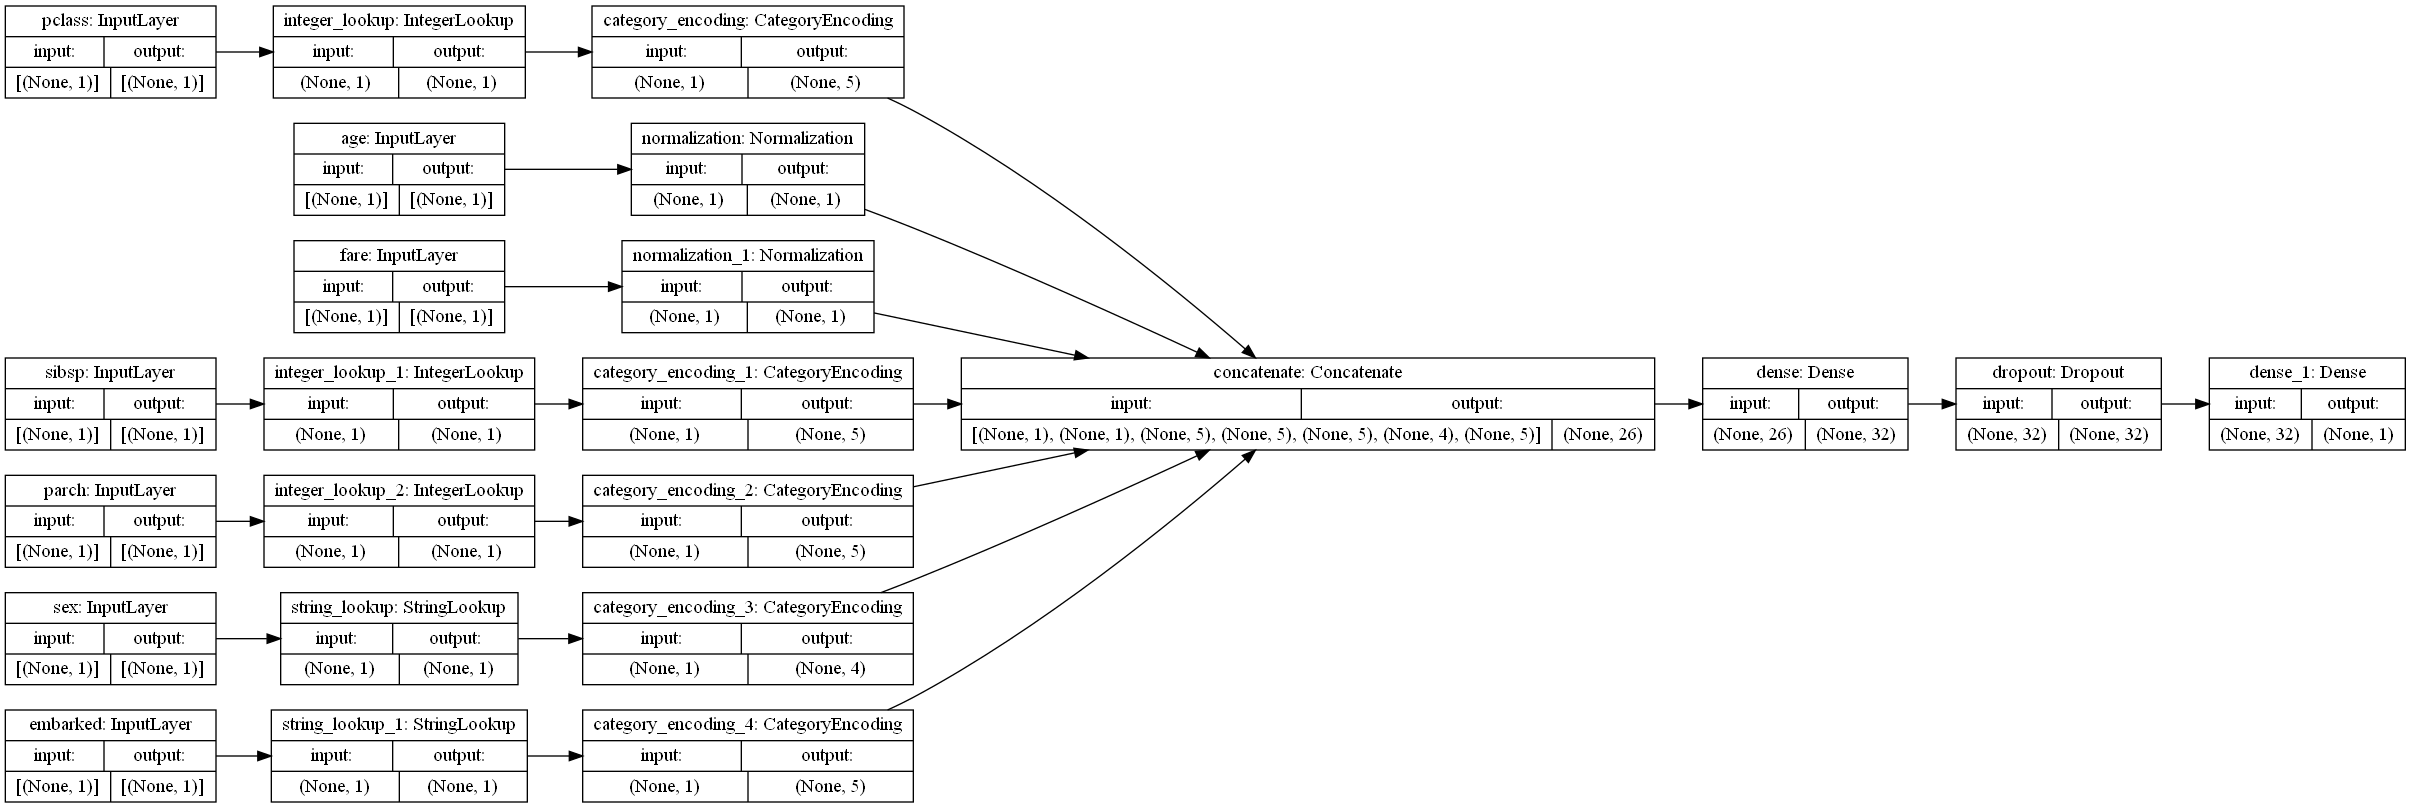

In [16]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


### Train the model

In [17]:
%%time
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 1s 56ms/step - loss: 0.7205 - accuracy: 0.5772 - val_loss: 0.7021 - val_accuracy: 0.6168
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7143 - accuracy: 0.6087 - val_loss: 0.6796 - val_accuracy: 0.6287
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.6252 - val_loss: 0.6598 - val_accuracy: 0.6347
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6117 - val_loss: 0.6423 - val_accuracy: 0.6407
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6363 - accuracy: 0.6267 - val_loss: 0.6272 - val_accuracy: 0.6647
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.6402 - val_loss: 0.6137 - val_accuracy: 0.6587
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6199 - accuracy: 0.6372 - val_loss: 0.6011 - val_accuracy: 0.6587
Epoch 8/10
7/7 [=================

### Evaluate the model

In [18]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)


3/3 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.6938
Accuracy 0.6937798857688904
Loss 0.554993748664856


### Save the model

In [19]:
model.save('my_keras_titanic_classifier')

INFO:tensorflow:Assets written to: my_keras_titanic_classifier\assets


### Reload the model

In [20]:
reloaded_model = tf.keras.models.load_model('my_keras_titanic_classifier')
loss, accuracy = reloaded_model.evaluate(test_ds)

3/3 [==============================] - 0s 3ms/step - loss: 0.5550 - accuracy: 0.6938


In [21]:
def predict_survival(sample):
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = reloaded_model.predict(input_dict)
    prob = tf.nn.sigmoid(predictions[0])
    print( "This person had a %.1f percent probability of survival." % (100 * prob))

### Predict using the model

In [22]:
%%time

predict_survival({
    'pclass': 1,
    'sex': 'female',
    'age': 7,
    'sibsp': 1,
    'parch': 2,
    'fare': 39.4000,
    'embarked': 'S'
})

predict_survival({
    'pclass': 1,
    'sex': 'male',
    'age': 7,
    'sibsp': 1,
    'parch': 2,
    'fare': 39.4000,
    'embarked': 'S'
})

This person had a 63.4 percent probability of survival.
This person had a 46.3 percent probability of survival.
Wall time: 393 ms
